## Bibliotek

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import scipy.io as sio
import skrf as rf

## Simulering

### IV-kurve og transkonduktans

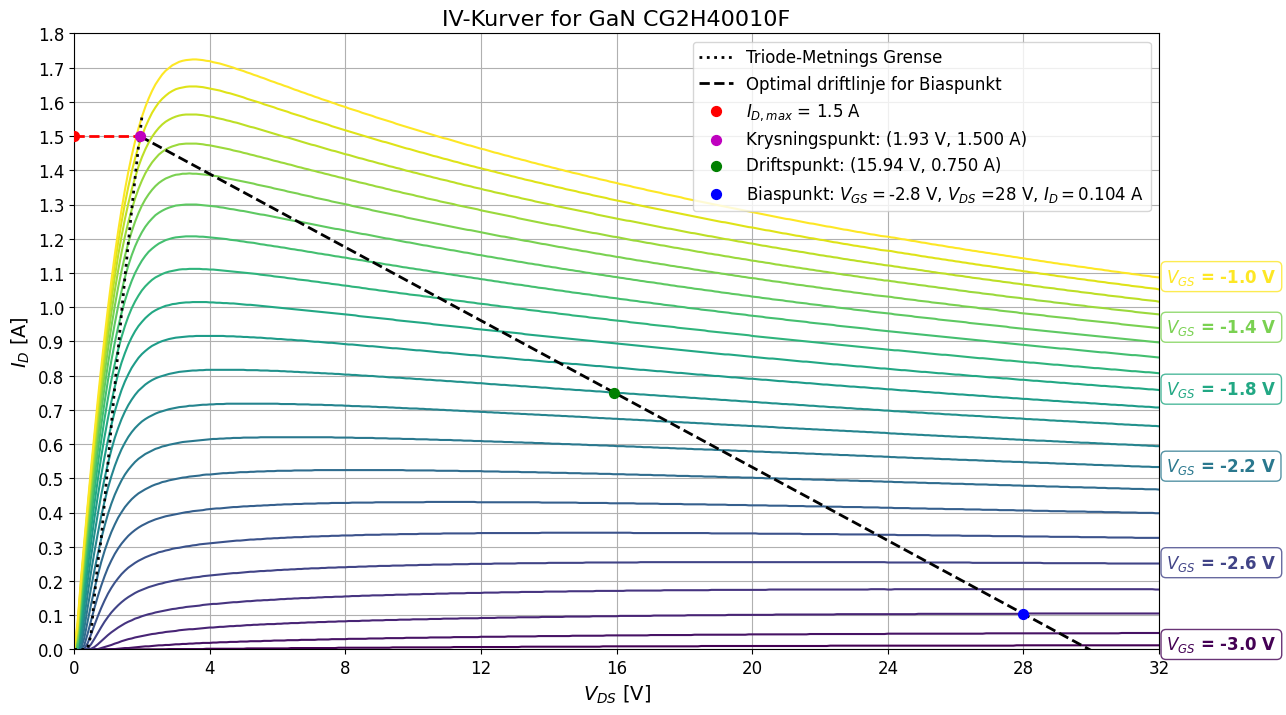

In [2]:
# Load IV data
IV_kurve01 = np.loadtxt('Data/Simulering/Transistorkarakteristikk/IV_kurve01.csv', delimiter=',', skiprows=16)
IV_kurve01 = pd.DataFrame(IV_kurve01, columns=['VGS', 'VDS', 'ID'])

Transkonduktans = np.loadtxt('Data/Simulering/Transistorkarakteristikk/Transkonduktans.csv', delimiter=',', skiprows=16)
Transkonduktans = pd.DataFrame(Transkonduktans, columns=['VGS', 'VDS', 'gm'])

# Create a colormap
unique_vgs = IV_kurve01['VGS'].unique()
IV_cmap = plt.get_cmap('viridis', len(unique_vgs))

# Define transistor parameters and bias point
Imax = 1.5

VDS_bias = 28
VGS_bias = -2.8
I_bias = IV_kurve01[(IV_kurve01['VGS'] == VGS_bias) & (IV_kurve01['VDS'] == VDS_bias)]['ID'].values[0]

# Function to calculate the triode-saturation boundary
def triode_saturation_boundary(IV_data):
    boundary_points = {'VDS': [], 'ID': []}  # Store boundary points

    for VGS in IV_data['VGS'].unique():
        Vth = -3  # Typical threshold voltage for CG2H40010F
        VDS_sat = VGS - Vth  # Calculate VDS at saturation boundary
        if VDS_sat >= 0:  # Only consider positive VDS values
            try:
                # Find the ID corresponding to VGS and VDS_sat
                ID_value = IV_data[(IV_data['VGS'] == VGS) & (IV_data['VDS'] >= VDS_sat)]['ID'].values[0]
                boundary_points['VDS'].append(VDS_sat)
                boundary_points['ID'].append(ID_value)
            except IndexError:
                # In case the specific VDS_sat is not found in the data
                continue

    return boundary_points['VDS'], boundary_points['ID']

# Calculate the boundary points
x_boundary, y_boundary = triode_saturation_boundary(IV_kurve01)

# Function to find VDS at Imax on the saturation boundary
def find_vds_at_imax(x_boundary, y_boundary, Imax):
    # Interpolate to find VDS where ID ≈ Imax
    VDS_at_Imax = np.interp(Imax, y_boundary, x_boundary)
    return VDS_at_Imax

# Calculate the VDS value at the boundary for Imax
VDS_at_Imax = find_vds_at_imax(x_boundary, y_boundary, Imax)

# Define the optimal load line function starting from the boundary point at Imax
def last_linje(x):
    # Calculate the slope for the line going from the saturation boundary at Imax to the bias point
    slope = (I_bias - Imax) / (VDS_bias - VDS_at_Imax)
    intercept = Imax - slope * VDS_at_Imax
    return slope * x + intercept

# Calculate the load line with the adjusted function
x_driftlinje = np.linspace(VDS_at_Imax, 32, 100)
y_driftlinje = last_linje(x_driftlinje)

# Define the function to find the intersection
def find_intersection(x_lastlinje, y_lastlinje, x_boundary, y_boundary):
    def equations(VDS):
        return np.interp(VDS, x_lastlinje, y_lastlinje) - np.interp(VDS, x_boundary, y_boundary)
    VDS_intersection = fsolve(equations, VDS_bias)[0]
    ID_intersection = np.interp(VDS_intersection, x_lastlinje, y_lastlinje)
    return VDS_intersection, ID_intersection

# Find the intersection point
VDS_intersection, ID_intersection = find_intersection(x_driftlinje, y_driftlinje, x_boundary, y_boundary)

VDS_at_I_zero = np.interp(0, y_driftlinje[::-1], x_driftlinje[::-1])
VDS_operating = (VDS_at_I_zero + VDS_intersection) / 2
ID_operating = (0 + ID_intersection) / 2

# Plot IV curves for different VGS values
plt.figure(figsize=(14, 8))
for i, vgs in enumerate(unique_vgs):
    subset = IV_kurve01[IV_kurve01['VGS'] == vgs]
    plt.plot(subset['VDS'], subset['ID'], color=IV_cmap(i))
    # Annotate the endpoint of each curve with the VGS value
    if i % 4 == 0:
        props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor=IV_cmap(i))
        plt.annotate('$V_{GS}$ = '+f'{vgs} V', xy=(subset['VDS'].iloc[-1], subset['ID'].iloc[-1]),
                     xytext=(5, -3), textcoords='offset points', bbox=props, fontsize=12, fontweight='bold', color=IV_cmap(i))

plt.plot(x_boundary, y_boundary, color='k', linestyle=':', linewidth=2, label='Triode-Metnings Grense')
plt.plot(x_driftlinje, y_driftlinje, color='k', linestyle='--', linewidth=2, label='Optimal driftlinje for Biaspunkt')
plt.plot([0, VDS_intersection], [Imax, Imax], color='r', linestyle='--', linewidth=2)

plt.scatter(0, Imax, color='r', s=50, zorder=10, label='$I_{D,max}$ = 1.5 A')
plt.scatter(VDS_intersection, ID_intersection, color='m', s=50, zorder=10, label='Krysningspunkt: '+f'({VDS_intersection:.2f} V, {ID_intersection:.3f} A)')
plt.scatter(VDS_operating, ID_operating, color='g', s=50, zorder=10, label=f'Driftspunkt: ({VDS_operating:.2f} V, {ID_operating:.3f} A)')
plt.scatter(VDS_bias, I_bias, color='b', s=50, zorder=10, label='Biaspunkt: $V_{GS} = $'+f'{VGS_bias}'+' V, $V_{DS}$ ='+f'{VDS_bias} V, ' + f'$I_D = {I_bias:.3f}$ A')

plt.xlabel('$V_{DS}$ [V]', fontsize=14)
plt.ylabel('$I_D$ [A]', fontsize=14)
plt.title('IV-Kurver for GaN CG2H40010F', fontsize=16)

plt.xlim(0, 32)
plt.ylim(0, 1.5)
plt.yticks(np.arange(0, 1.8 + 0.1, 0.1), fontsize=12)
plt.xticks(np.arange(0, 32.1, 4), fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()



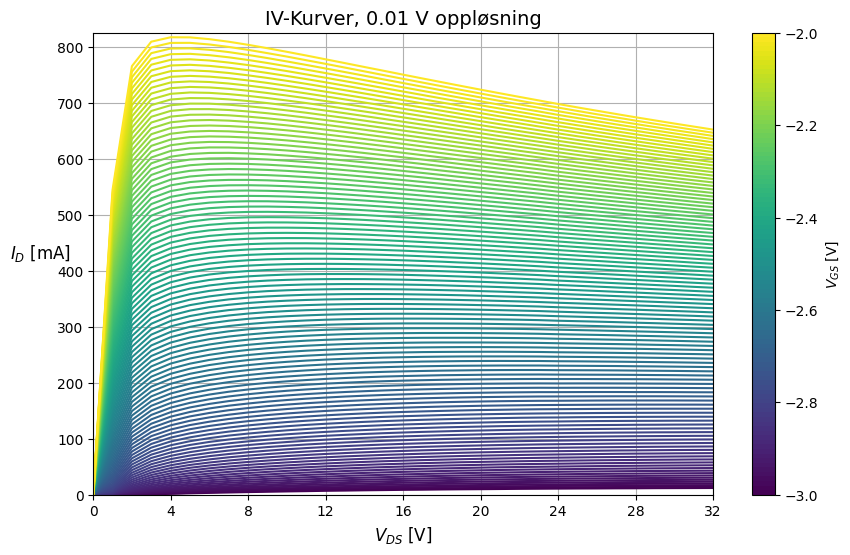

In [3]:
# Load IV data
IV_kurve = np.loadtxt('Data/Simulering/Transistorkarakteristikk/IV_kurve.csv', delimiter=',', skiprows=17)
IV_kurve = pd.DataFrame(IV_kurve, columns=['VGS', 'VDS', 'ID'])

# Convert current from A to mA
IV_kurve['ID'] = IV_kurve['ID'] * 1000

# Create a colormap
unique_vgs = IV_kurve['VGS'].unique()
norm = mcolors.Normalize(vmin=unique_vgs.min(), vmax=unique_vgs.max())  # Normalize the VGS values
IV_cmap = plt.get_cmap('viridis', len(unique_vgs))

# Plot IV curves for different VGS values
fig, ax = plt.subplots(figsize=(10, 6))

for i, vgs in enumerate(unique_vgs):
    subset = IV_kurve[IV_kurve['VGS'] == vgs]
    ax.plot(subset['VDS'], subset['ID'], color=IV_cmap(norm(vgs)))  # Use normalized VGS for color

# Add colorbar for the VGS values
sm = cm.ScalarMappable(cmap=IV_cmap, norm=norm)  # Create ScalarMappable for the colorbar
sm.set_array([])  # Set array to allow ScalarMappable to work
cbar = plt.colorbar(sm, ax=ax, label='$V_{GS}$ [V]')  # Add the colorbar linked to the plot

# Set x-ticks and labels
ax.set_xticks(np.arange(0, 32.1, 4))
ax.set_xlabel('$V_{DS}$ [V]', fontsize=12)
ax.set_ylabel('$I_{D}$ [mA]', fontsize=12, labelpad=12, rotation=0)
ax.set_title('IV-Kurver, 0.01 V oppløsning', fontsize=14)
ax.set_xlim(0, 32)
ax.set_ylim(0, 825)

# Add grid and show the plot
ax.grid(True)
plt.show()


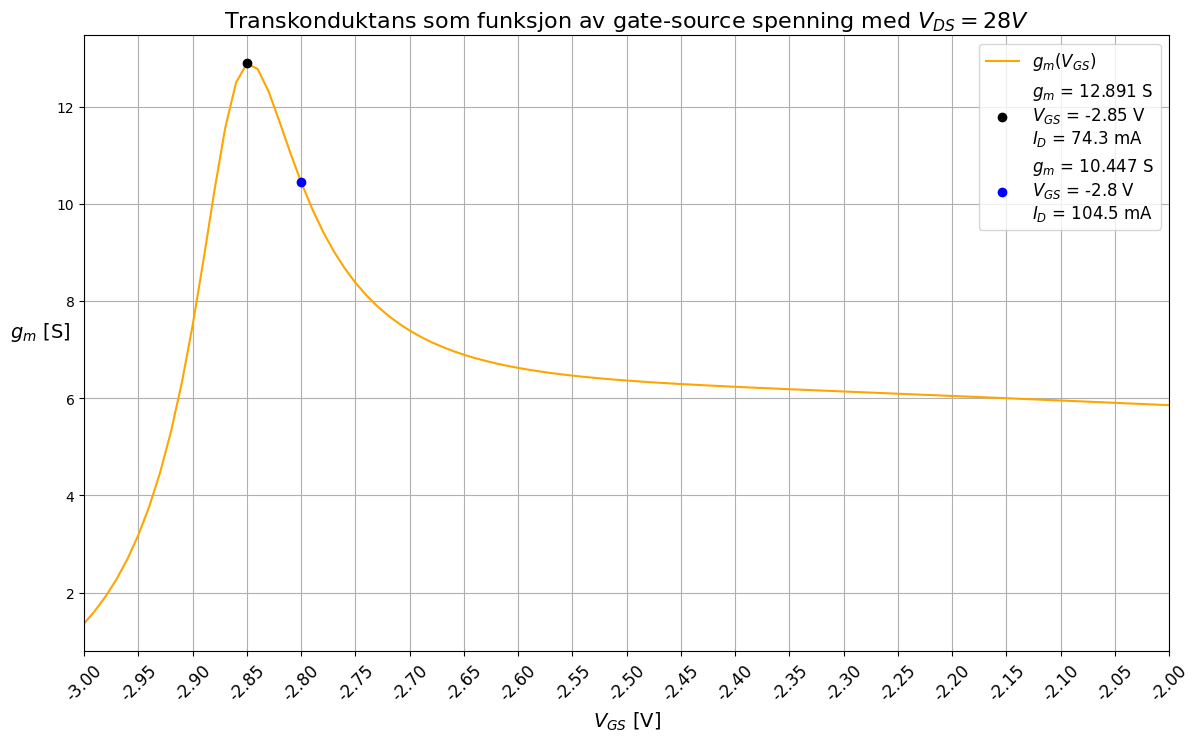

In [4]:
# Load transkonduktans data
Transkonduktans28V = np.loadtxt('Data/Simulering/Transistorkarakteristikk/Transkonduktans28V.csv', delimiter=',', skiprows=11)
Transkonduktans28V = pd.DataFrame(Transkonduktans28V, columns=['VGS', 'Gm'])

# Find the maximum gm value and corresponding VGS
max_gm_idx = Transkonduktans28V['Gm'].idxmax()
max_gm = Transkonduktans28V.loc[max_gm_idx]
max_ID = IV_kurve[IV_kurve['VGS'] == max_gm['VGS']]['ID'].max()

# Find gm and ID for VGS = -2.8
gm_2_8 = Transkonduktans28V[Transkonduktans28V['VGS'] == -2.8]['Gm'].values[0]
id_2_8 = IV_kurve[(IV_kurve['VGS'] == -2.8) & (IV_kurve['VDS'] == 28)]['ID'].values[0]

# Plot the transconductance curve
plt.figure(figsize=(14, 8))
plt.plot(Transkonduktans28V['VGS'], Transkonduktans28V['Gm'], color='orange', label=f'$g_m(V_{{GS}})$')

# Highlight the maximum gm point
plt.scatter(max_gm['VGS'], max_gm['Gm'], marker='o', color='k', label=f'$g_m$ = {max_gm["Gm"]:.3f} S\n$V_{{GS}}$ = {max_gm["VGS"]:.2f} V \n$I_D$ = {max_ID:.1f} mA', zorder=5)

# Highlight the gm point for VGS = -2.8
plt.scatter(-2.8, gm_2_8, marker='o', color='b', label=f'$g_m$ = {gm_2_8:.3f} S\n$V_{{GS}}$ = -2.8 V \n$I_D$ = {id_2_8:.1f} mA', zorder=5)

# Set plot labels and title
plt.xlabel('$V_{GS}$ [V]', fontsize=14)
plt.ylabel('$g_m$ [S]', fontsize=14, labelpad=12, rotation=0)
plt.title('Transkonduktans som funksjon av gate-source spenning med $V_{DS} = 28 V$', fontsize=16)
plt.grid(True)
plt.xticks(np.arange(-3, -2+0.01, 0.05), rotation=45, fontsize=12)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.legend(fontsize=12)
plt.xlim(-3, -2)
plt.show()

### S21 og stabilitet

1 dB Bandwidth centered around 2.4 GHz: 119 MHz
1 dB Bandwidth centered around 2.15 GHz: 111 MHz


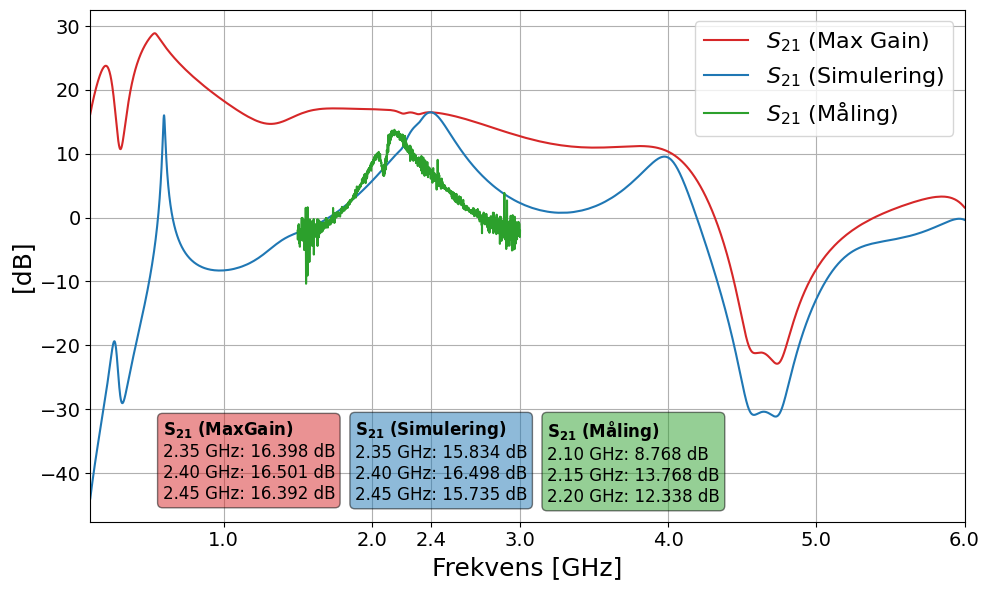

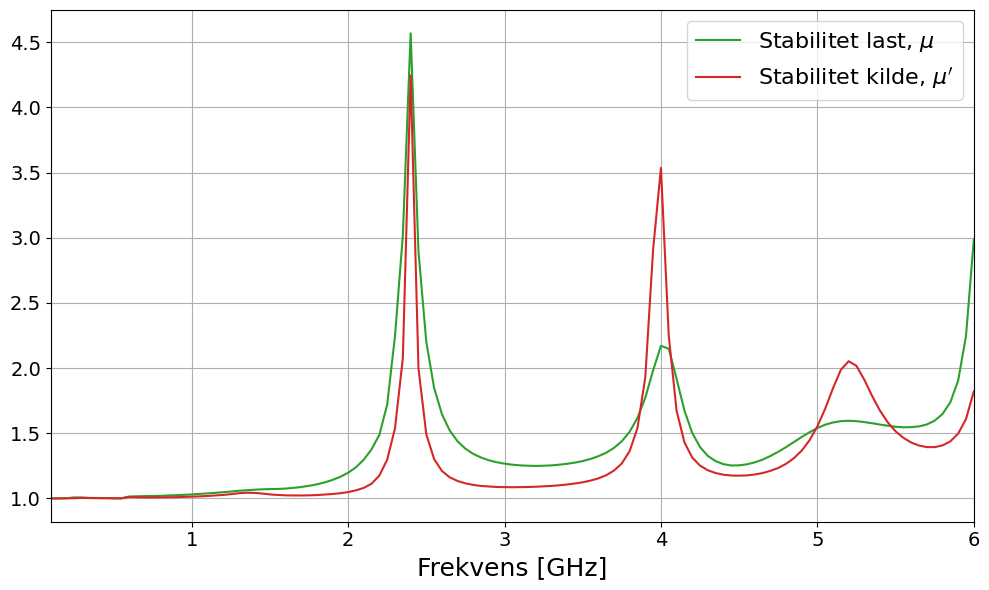

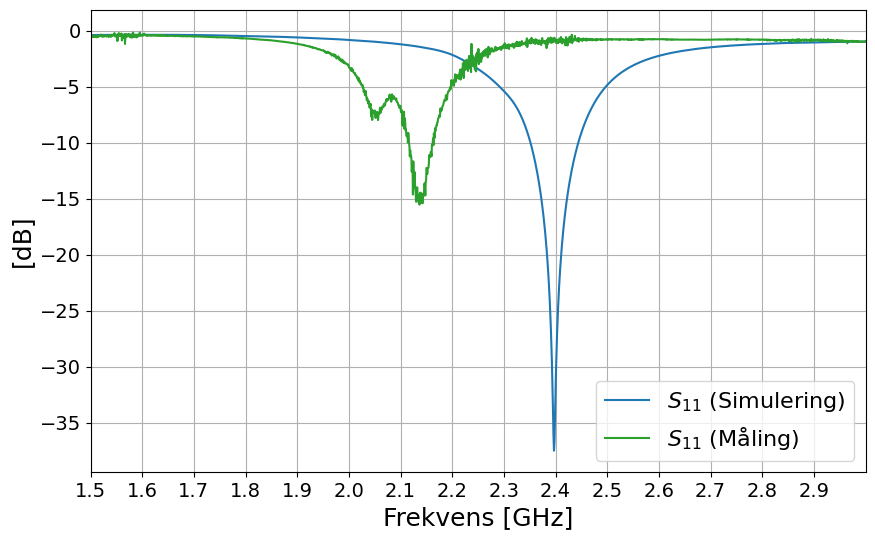

In [5]:
stabilitet = np.loadtxt('Data/Simulering/S_param/stab_factor.csv', delimiter=',', skiprows=16)
stabilitet = pd.DataFrame(stabilitet, columns=['Frekvens', 'Stabilitet last', 'Stabilitet kilde'])

MAG_S21 = np.loadtxt('Data/Simulering/S_param/MAG_S21_S11.csv', delimiter=',', skiprows=21)
MAG_S21 = pd.DataFrame(MAG_S21, columns=['Frekvens', 'Mag', 'S21', 'S11'])

stabilitet['Frekvens'] = stabilitet['Frekvens'] / 1e9
MAG_S21['Frekvens'] = MAG_S21['Frekvens'] / 1e9

# Find the peak value of S21 at 2.4 GHz
center_freq = 2.4
peak_s21 = MAG_S21.loc[MAG_S21['Frekvens'] == center_freq, 'S21'].values[0]

# Determine the frequencies where S21 is within 1 dB of the peak value
within_1db = MAG_S21[(MAG_S21['S21'] >= (peak_s21 - 1)) & (abs(MAG_S21['Frekvens'] - center_freq) <= 0.5)]

# Calculate the 1 dB bandwidth
bandwidth_1db = (within_1db['Frekvens'].max() - within_1db['Frekvens'].min()) * 10**3

print(f"1 dB Bandwidth centered around 2.4 GHz: {bandwidth_1db:.0f} MHz")

# Load the s2p file
S_Measured = rf.Network('Data/Måling/group6sparam.s2p')
S21_Measured = pd.DataFrame({
    'Frekvens': S_Measured.f / 1e9,
    'Value': 20 * np.log10(abs(S_Measured.s[:, 1, 0]))
})
S11_Measured = pd.DataFrame({
    'Frekvens': S_Measured.f / 1e9,
    'Value': 20 * np.log10(abs(S_Measured.s[:, 0, 0]))
})

# Find the peak value of S21 at 2.15 GHz
center_freq = 2.1525
peak_s21_measured = S21_Measured.loc[S21_Measured['Frekvens'] == center_freq, 'Value'].values[0]

# Determine the frequencies where S21 is within 1 dB of the peak value
within_1db_measured = S21_Measured[(S21_Measured['Value'] >= (peak_s21_measured - 1)) & (abs(S21_Measured['Frekvens'] - center_freq) <= 0.5)]

# Calculate the 1 dB bandwidth
bandwidth_1db_measured = (within_1db_measured['Frekvens'].max() - within_1db_measured['Frekvens'].min()) * 10**3

print(f"1 dB Bandwidth centered around 2.15 GHz: {bandwidth_1db_measured:.0f} MHz")


freqs = [2.35, 2.40, 2.45]
freqs_measured = [2.1, 2.1525, 2.2005]
s21_values = {freq: MAG_S21.loc[MAG_S21['Frekvens'] == freq, 'S21'].values[0] for freq in freqs}
s21_values_max_gain = {freq: MAG_S21.loc[MAG_S21['Frekvens'] == freq, 'Mag'].values[0] for freq in freqs}
s21_values_measured = {freq: S21_Measured.loc[S21_Measured['Frekvens'] == freq, 'Value'].values[0] for freq in freqs_measured}

# Plot MAG_S21 (Figure 1)
plt.figure(figsize=(10, 6))
plt.plot(MAG_S21['Frekvens'], MAG_S21['Mag'], label=r'$S_{21}$ (Max Gain)', color='tab:red')
plt.plot(MAG_S21['Frekvens'], MAG_S21['S21'], label=r'$S_{21}$ (Simulering)', color='tab:blue')
plt.plot(S21_Measured['Frekvens'], S21_Measured['Value'], label=r'$S_{21}$ (Måling)', color='tab:green')
plt.xlabel('Frekvens [GHz]', fontsize=18)
plt.ylabel('[dB]', fontsize=18)
plt.legend(fontsize=16, loc='upper right')
plt.grid(True)
#plt.title('S21 og Max Gain S21', fontsize=20)

# Set x-ticks to ensure 2.4 GHz is included
xticks = list(plt.gca().get_xticks())  # Get current x-ticks
if 2.4 not in xticks:
    xticks.append(2.4)  # Add 2.4 GHz if it's not already in the list
xticks.sort()  # Sort the ticks
plt.xticks(xticks, fontsize=14)  # Set the new x-ticks
plt.xlim(0.1, 6)

# Annotate the S21 values in a box right under the legend
textstr = r'$\mathbf{S_{21}\ (Max Gain)}$' + '\n' + '\n'.join([f'{freq:.2f} GHz: {s21_values_max_gain[freq]:.3f} dB' for freq in freqs])
props = dict(boxstyle='round', facecolor='tab:red', alpha=0.5)
plt.gca().text(0.28, 0.2, textstr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', horizontalalignment='right', bbox=props, multialignment='left')

textstr = r'$\mathbf{S_{21}\ (Simulering)}$' + '\n' + '\n'.join([f'{freq:.2f} GHz: {s21_values[freq]:.3f} dB' for freq in freqs])
props = dict(boxstyle='round', facecolor='tab:blue', alpha=0.5)
plt.gca().text(0.5, 0.2, textstr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', horizontalalignment='right', bbox=props, multialignment='left')

textstr = r'$\mathbf{S_{21}\ (Måling)}$' + '\n' + '\n'.join([f'{freq:.2f} GHz: {s21_values_measured[freq]:.3f} dB' for freq in freqs_measured])
props = dict(boxstyle='round', facecolor='tab:green', alpha=0.5)
plt.gca().text(0.72, 0.2, textstr, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', horizontalalignment='right', bbox=props, multialignment='left')

# Increase tick label size
plt.gca().tick_params(axis='both', which='major', labelsize=14)

# Show plot
plt.tight_layout()
plt.show()

# Plot Stabilitet last and Stabilitet kilde (Figure 2)
plt.figure(figsize=(10, 6))
plt.plot(stabilitet['Frekvens'], stabilitet['Stabilitet last'], color='tab:green', label=r'Stabilitet last, $\mu$')
plt.plot(stabilitet['Frekvens'], stabilitet['Stabilitet kilde'], color='tab:red', label=r'Stabilitet kilde, $\mu^{\prime}$')
plt.xlabel('Frekvens [GHz]', fontsize=18)
plt.legend(fontsize=16)
plt.grid(True)
#plt.title('Stabilitet', fontsize=20)
plt.xlim(0.1, 6)

# Increase tick label size
plt.gca().tick_params(axis='both', which='major', labelsize=14)

# Show plot
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(MAG_S21['Frekvens'], MAG_S21['S11'], label=r'$S_{11}$ (Simulering)', color='tab:blue')
plt.plot(S11_Measured['Frekvens'], S11_Measured['Value'], label=r'$S_{11}$ (Måling)', color='tab:green')
plt.xlabel('Frekvens [GHz]', fontsize=18)
plt.ylabel('[dB]', fontsize=18)
plt.legend(fontsize=16, loc='lower right')
plt.grid(True)
plt.xlim(1.50, 3.00)
plt.xticks(np.arange(1.5,3.0, 0.1),fontsize=14) 
plt.yticks(fontsize=14)

plt.grid(True)
plt.show()

### 1-tone HB

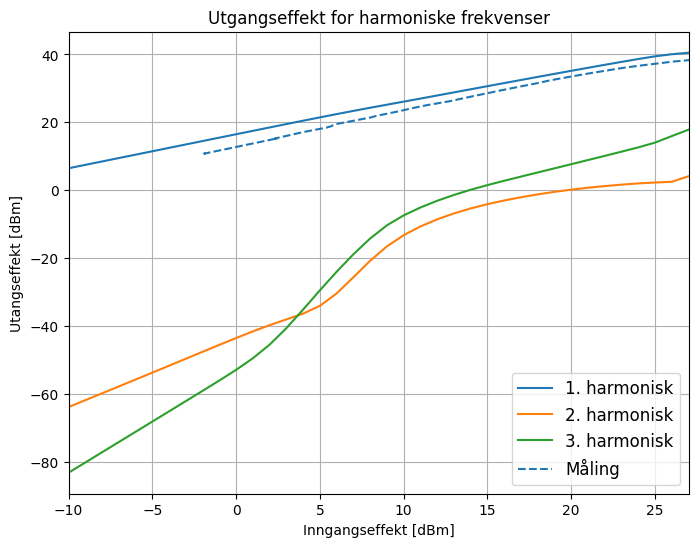

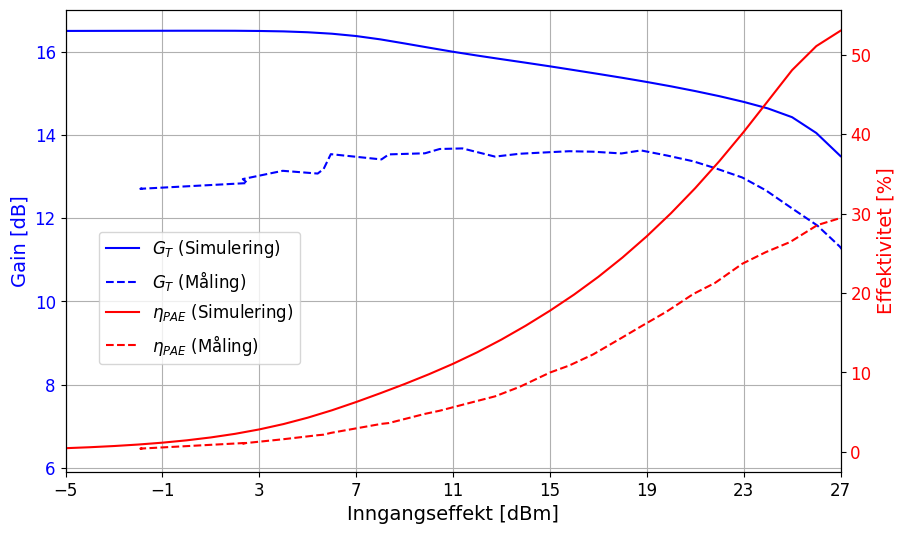

In [6]:
P_ut = np.loadtxt('Data/Simulering/HB_1Tone/Put.csv', delimiter=',',skiprows=21)
P_ut = pd.DataFrame(P_ut, columns=['P_in', 'P_ut1', 'P_ut2', 'P_ut3'])

TransGain = np.loadtxt('Data/Simulering/HB_1Tone/TransGain.csv', delimiter=',',skiprows=11)
TransGain = pd.DataFrame(TransGain, columns=['P_in', 'Gain'])

Effektivitet = np.loadtxt('Data/Simulering/HB_1Tone/Effektivitet.csv', delimiter=',',skiprows=21)
Effektivitet = pd.DataFrame(Effektivitet, columns=['P_in', 'DrainEff', 'TotalEff', 'PAE'])

# Load the .mat file
mat_data = sio.loadmat('Data/Måling/group_6_2.mat')
PA1Tone = mat_data['PA_1tone'][0][0]

length = len(PA1Tone[0].flatten())
data_dict = {label: PA1Tone[i].flatten() if i != 4 and i != 6 else [PA1Tone[i][0][0]] * length 
             for i, label in enumerate(['Pi_dBm', 'Po_dBm', 'Gain_dB', 'Idrain', 'Vdrain', 'PAE', 'freq'])}

PA1Tone = pd.DataFrame(data_dict)


plt.figure(figsize=(8, 6))
plt.plot(P_ut['P_in'], P_ut['P_ut1'], label='1. harmonisk')
plt.plot(P_ut['P_in'], P_ut['P_ut2'], label='2. harmonisk')
plt.plot(P_ut['P_in'], P_ut['P_ut3'], label='3. harmonisk')
plt.plot(PA1Tone['Pi_dBm'], PA1Tone['Po_dBm'], color='tab:blue', linestyle='--', label='Måling')
plt.xlabel('Inngangseffekt [dBm]')
plt.ylabel('Utangseffekt [dBm]')
plt.xlim(-10, 27)
plt.legend(fontsize=12)
plt.title('Utgangseffekt for harmoniske frekvenser')
plt.grid(True)
plt.show()

fig, ax1 = plt.subplots(figsize=(10, 6))

# First plot
ax1.plot(TransGain['P_in'], TransGain['Gain'], 'b-', label='$G_T$ (Simulering)')
ax1.plot(PA1Tone['Pi_dBm'], PA1Tone['Gain_dB'], 'b--', label='$G_T$ (Måling)')
ax1.set_xlabel('Inngangseffekt [dBm]', fontsize=14)
ax1.set_ylabel('Gain [dB]', color='b', fontsize=14)
ax1.tick_params(axis='y', labelcolor='b', labelsize=12)
ax1.tick_params(axis='x', labelsize=12)
#ax1.set_title(r'Transducer Gain $G_T$ og Effektivitet $\eta_{PAE}$ som funksjon av inngangseffekt', fontsize=16)
ax1.grid(True)
ax1.set_xlim(-5, 27)
ax1.set_xticks(np.arange(-5, 27+1, 4))

# Second y-axis
ax2 = ax1.twinx()
ax2.plot(Effektivitet['P_in'], Effektivitet['PAE'], 'r-', label=r'$\eta_{PAE}$ (Simulering)')
ax2.plot(PA1Tone['Pi_dBm'], PA1Tone['PAE'], 'r--', label=r'$\eta_{PAE}$ (Måling)')
ax2.set_ylabel('Effektivitet [%]', color='r', fontsize=14)
ax2.tick_params(axis='y', labelcolor='r', labelsize=12)

# Adding legend for the second y-axis
fig.legend(loc='center left', bbox_to_anchor=(0.15, 0.4), fontsize=12)

plt.show()


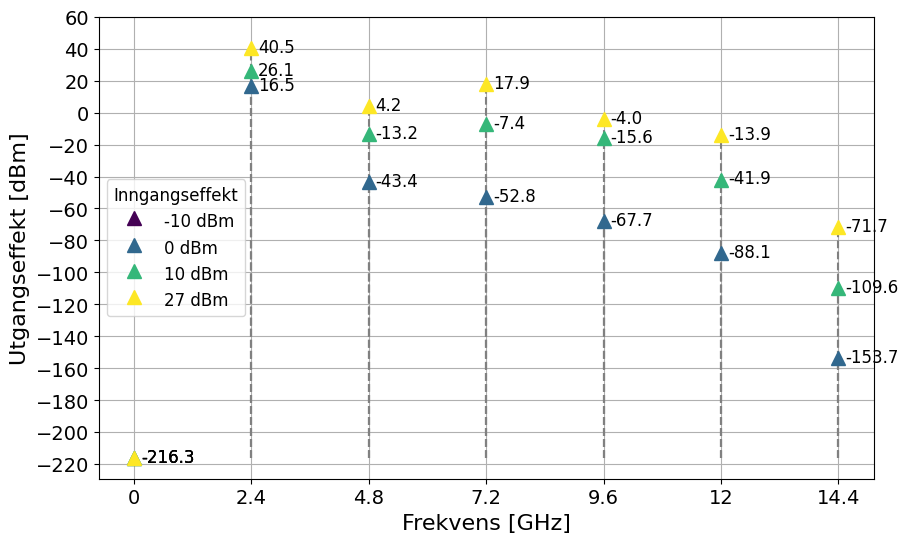

In [7]:
# Load the data
Spektrum1Tone = pd.read_csv('Data/Simulering/HB_1Tone/Spektrum1Tone.csv', delimiter=',', names=['RFPower', 'Frequency', 'Value'], na_values='<invalid>', skiprows=16)
Spektrum1Tone = Spektrum1Tone.dropna()  # Drop rows with NaN values
Spektrum1Tone['Frequency'] = Spektrum1Tone['Frequency'] / 1e9  # Convert frequency to GHz

# Define the harmonics of 2.4 GHz
harmonic_frequencies = [0, 2.4, 4.8, 7.2, 9.6, 12, 14.4]  # GHz

min_value = Spektrum1Tone['Value'].min()
max_value = Spektrum1Tone['Value'].max()
step = 20

# Desired input power values
Power_values = [-10, 0, 10, 27]  # dBm
cmap = plt.get_cmap('viridis', len(Power_values))

# Plot the spectral lines at the desired input power
plt.figure(figsize=(10, 6))

for i, Power in enumerate(Power_values):
    # Select rows with the current RFPower value
    idx = (Spektrum1Tone['RFPower'] == Power)
    freqs = Spektrum1Tone[idx]['Frequency']
    values = Spektrum1Tone[idx]['Value']
    
    # Plot stem plot
    markerline, stemlines, baseline = plt.stem(
        freqs, 
        values, 
        linefmt='--', 
        markerfmt='^', 
        basefmt=' ', 
        label=f'{Power} dBm',
        bottom=int(min_value)
    )
    
    plt.setp(markerline, 'zorder', 3, 'markersize', 10, 'color', cmap(i))  # Set marker z-order, size, and color
    plt.setp(stemlines, 'zorder', 2, 'color', 'gray')  # Set stem line z-order and color
    plt.setp(baseline, 'zorder', 1) 
    
    # Annotate values at harmonic frequencies if they exist in `freqs`
    for x, y in zip(freqs, values):
        plt.annotate(f'{y:.1f}', xy=(x, y), xytext=(5, -3), textcoords='offset points', fontsize=12, color='black')

# Configure plot ticks and labels
plt.xticks(harmonic_frequencies, [f'{freq}' for freq in harmonic_frequencies], fontsize=14) 
plt.yticks(np.arange(np.floor(min_value / step) * step, np.ceil(max_value / step) * step + 1, step), fontsize=14)
plt.xlabel('Frekvens [GHz]', fontsize=16)
plt.ylabel('Utgangseffekt [dBm]', fontsize=16)
plt.legend(title="Inngangseffekt", title_fontsize=12, fontsize=12, loc='center left')
plt.grid(True)
plt.show()

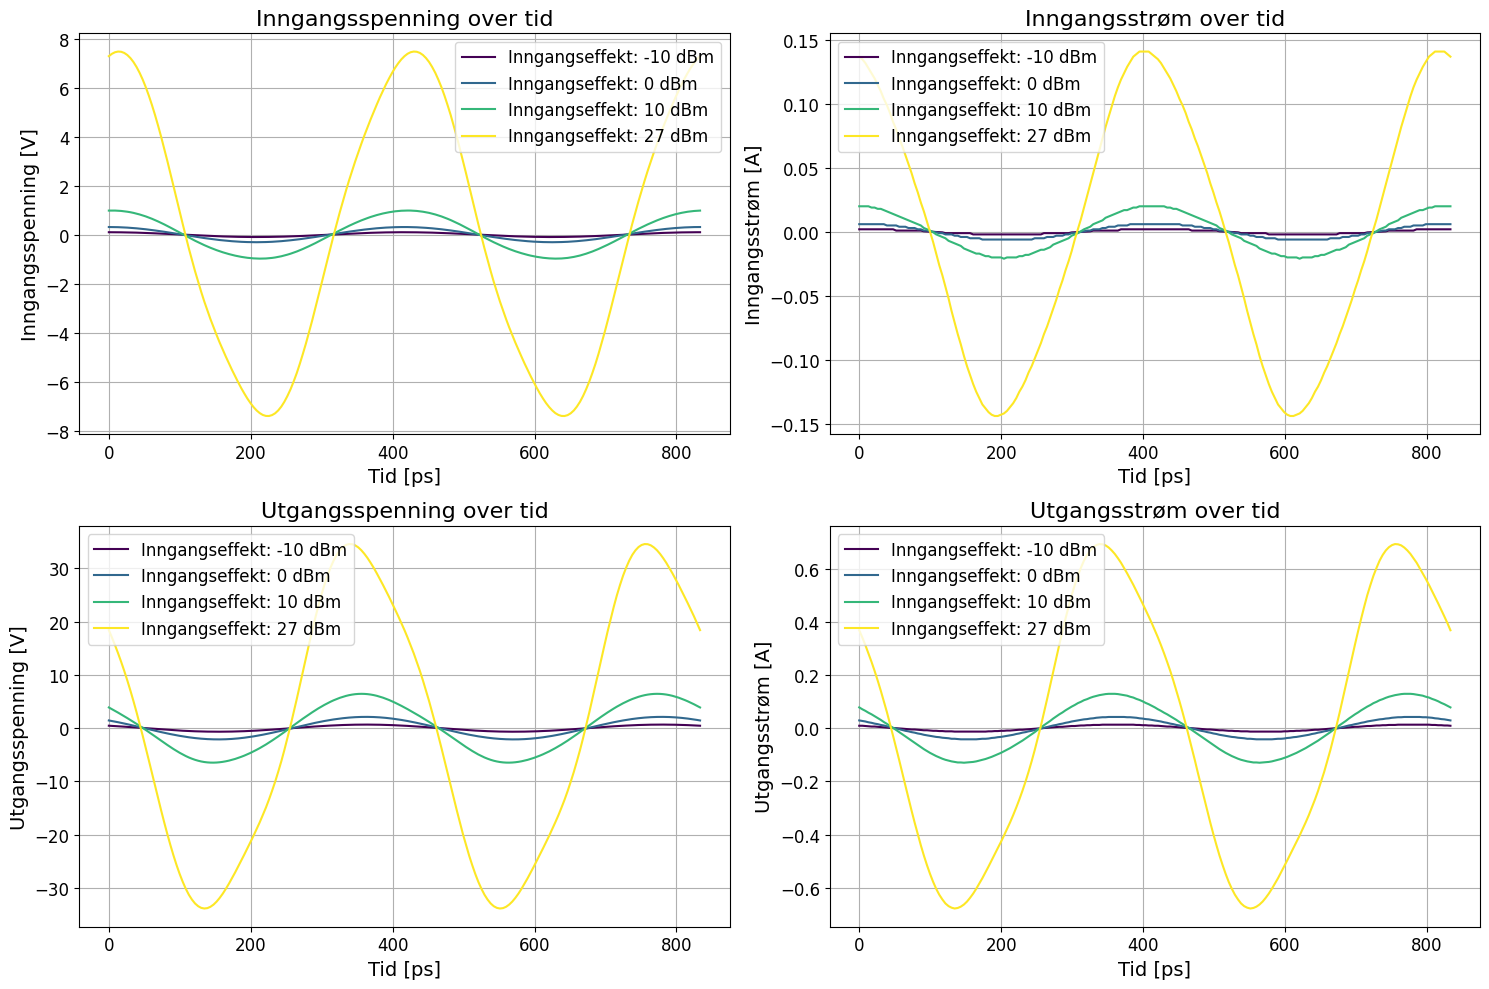

In [8]:
# Load the data
Tidsserier1Tone = np.loadtxt('Data/Simulering/HB_1Tone/Tidsserier1Tone.csv', delimiter=',', skiprows=31)
Tidsserier1Tone = pd.DataFrame(Tidsserier1Tone, columns=['P_in', 'Time', 'V_in', 'I_in', 'V_out', 'I_out'])

# Convert Time to picoseconds
Tidsserier1Tone['Time'] = Tidsserier1Tone['Time'] * 1e12

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot V_in versus Time
for i, Power in enumerate(Power_values):
    subset = Tidsserier1Tone[Tidsserier1Tone['P_in'] == Power]
    axs[0, 0].plot(subset['Time'], subset['V_in'], label=f'Inngangseffekt: {Power} dBm', color=cmap(i))
axs[0, 0].set_xlabel('Tid [ps]', fontsize=14)
axs[0, 0].set_ylabel('Inngangsspenning [V]', fontsize=14)
axs[0, 0].set_title('Inngangsspenning over tid', fontsize=16)
axs[0, 0].legend(fontsize=12)
axs[0, 0].grid(True)

# Plot I_in versus Time
for i, Power in enumerate(Power_values):
    subset = Tidsserier1Tone[Tidsserier1Tone['P_in'] == Power]
    axs[0, 1].plot(subset['Time'], subset['I_in'], label=f'Inngangseffekt: {Power} dBm', color=cmap(i))
axs[0, 1].set_xlabel('Tid [ps]', fontsize=14)
axs[0, 1].set_ylabel('Inngangsstrøm [A]', fontsize=14)
axs[0, 1].set_title('Inngangsstrøm over tid', fontsize=16)
axs[0, 1].legend(fontsize=12)
axs[0, 1].grid(True)

# Plot V_out versus Time
for i, Power in enumerate(Power_values):
    subset = Tidsserier1Tone[Tidsserier1Tone['P_in'] == Power]
    axs[1, 0].plot(subset['Time'], subset['V_out'], label=f'Inngangseffekt: {Power} dBm', color=cmap(i))
axs[1, 0].set_xlabel('Tid [ps]', fontsize=14)
axs[1, 0].set_ylabel('Utgangsspenning [V]', fontsize=14)
axs[1, 0].set_title('Utgangsspenning over tid', fontsize=16)
axs[1, 0].legend(fontsize=12)
axs[1, 0].grid(True)

# Plot I_out versus Time
for i, Power in enumerate(Power_values):
    subset = Tidsserier1Tone[Tidsserier1Tone['P_in'] == Power]
    axs[1, 1].plot(subset['Time'], subset['I_out'], label=f'Inngangseffekt: {Power} dBm', color=cmap(i))
axs[1, 1].set_xlabel('Tid [ps]', fontsize=14)
axs[1, 1].set_ylabel('Utgangsstrøm [A]', fontsize=14)
axs[1, 1].set_title('Utgangsstrøm over tid', fontsize=16)
axs[1, 1].legend(fontsize=12)
axs[1, 1].grid(True)

# Increase tick label size
for ax in axs.flat:
    ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

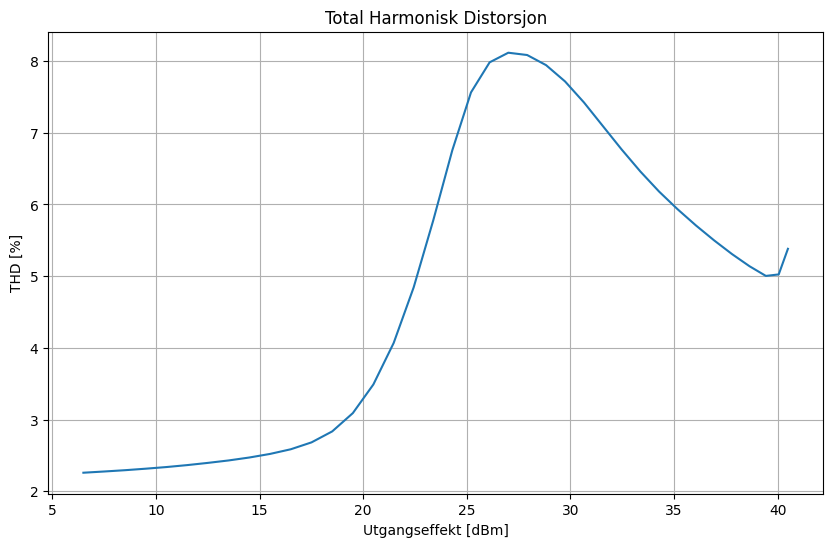

In [9]:
THD = np.loadtxt('Data/Simulering/HB_1Tone/THD1Tone.csv', delimiter=',', skiprows=11)
THD = pd.DataFrame(THD, columns=['P_ut', 'THD'])

plt.figure(figsize=(10, 6))
plt.plot(THD['P_ut'], THD['THD'])
plt.xlabel('Utgangseffekt [dBm]')
plt.ylabel('THD [%]')
plt.title('Total Harmonisk Distorsjon')
plt.grid(True)

### 2-Tone HB

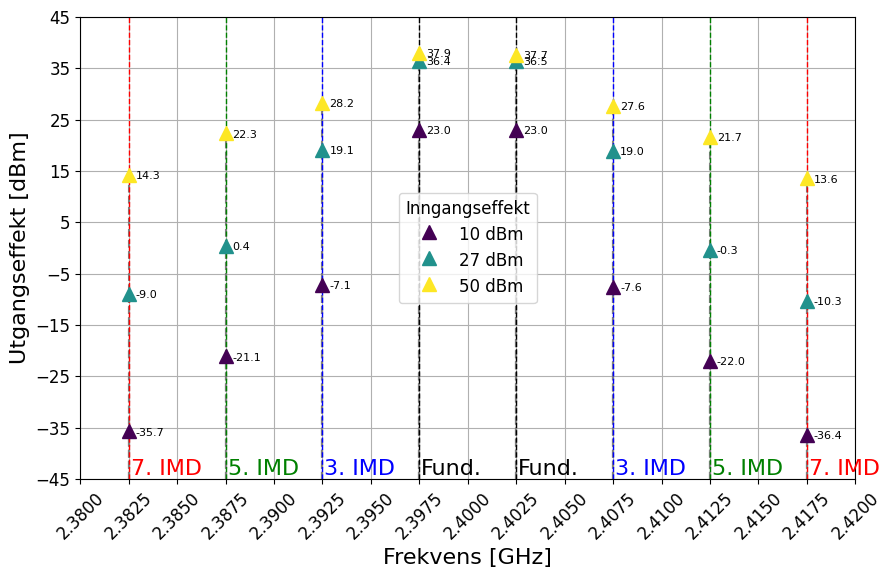

In [10]:
# Load the data
Spektrum2Tone = pd.read_csv('Data/Simulering/HB_2Tone/Spektrum2Tone.csv', delimiter=',', names=['RFPower', 'Frequency', 'Value'],na_values='<invalid>', skiprows=16)

mat_data = sio.loadmat('Data/Måling/group_6_2.mat')
PA2Tone = mat_data['PA_2tone'][0][0]

# Extract and create DataFrame
PA2Tone = pd.DataFrame({
    'Pi_dBm_f1': PA2Tone['Pi_dBm_f1'][0],
    'Pi_dBm_f2': PA2Tone['Pi_dBm_f2'][0],
    'Po_dBm_f1': PA2Tone['Po_dBm_f1'][0],
    'Po_dBm_f2': PA2Tone['Po_dBm_f2'][0],
    'TOIMD_dBc_low': PA2Tone['TOIMD_dBc_low'][0],
    'TOIMD_dBc_high': PA2Tone['TOIMD_dBc_high'][0],
    'Idrain': PA2Tone['Idrain'][0],
    'PAE': PA2Tone['PAE'][0],
    'freq': PA2Tone['freq'][0][0],
    'freqSpacing': PA2Tone['freqSpacing'][0][0],
    'Vdrain': PA2Tone['Vdrain'][0][0]
})
PA2Tone['Po_both'] = 10*np.log10(10**(PA2Tone['Po_dBm_f1']/10) + 10**(PA2Tone['Po_dBm_f2']/10))
PA2Tone['Pi_both'] = PA2Tone['Pi_dBm_f1'] + 3

Fund_freqs = [2.3975, 2.4025]
imd_3rd = [2 * Fund_freqs[0] - Fund_freqs[1], 2 * Fund_freqs[1] - Fund_freqs[0]]
imd_5th = [3 * Fund_freqs[0] - 2 * Fund_freqs[1], 3 * Fund_freqs[1] - 2 * Fund_freqs[0]]
imd_7th = [4 * Fund_freqs[0] - 3 * Fund_freqs[1], 4 * Fund_freqs[1] - 3 * Fund_freqs[0]]

# Slice data to only include frequencies between 2.3 and 2.5 GHz and convert to GHz
Spektrum2Tone_Fund = Spektrum2Tone[(Spektrum2Tone['Frequency'] < 2.5e9) & (Spektrum2Tone['Frequency'] > 2.3e9)].copy()
Spektrum2Tone_Fund['Frequency'] = Spektrum2Tone_Fund['Frequency'] / 1e9

min_value = Spektrum2Tone_Fund['Value'].min()

Power_values = [10, 27, 50]  # dBm
cmap = plt.get_cmap('viridis', len(Power_values))

plt.figure(figsize=(10, 6))
for i, Power in enumerate(Power_values):
    idx = (Spektrum2Tone_Fund['RFPower'] == Power)
    freqs = Spektrum2Tone_Fund[idx]['Frequency']
    values = Spektrum2Tone_Fund[idx]['Value']
    
    markerline, stemlines, baseline = plt.stem(
        freqs, 
        values, 
        linefmt='--', 
        markerfmt='^', 
        basefmt=' ', 
        label=f'{Power} dBm',
        bottom=min_value
    )
    plt.setp(markerline, 'zorder', 3, 'markersize', 10, 'color', cmap(i))  # Set marker z-order, size, and color
    plt.setp(stemlines, 'zorder', 2, 'color', 'gray')   # Set stem line z-order and color
    plt.setp(baseline, 'zorder', 1)  # Set baseline z-order

    for x, y in zip(freqs, values):
        plt.annotate(f'{y:.1f}', xy=(x, y), xytext=(5, -3), textcoords='offset points', fontsize=8, color='black')

# Annotate IMD products with vertical lines and text labels
for fund in Fund_freqs:
    plt.axvline(x=fund, color='k', linestyle='--', linewidth=1)
    plt.text(fund+0.0001, -45, 'Fund.', verticalalignment='bottom', fontsize=16)

for imd_freq in imd_3rd:
    plt.axvline(x=imd_freq, color='b', linestyle='--', linewidth=1)
    plt.text(imd_freq+0.0001, -45, '3. IMD', verticalalignment='bottom', fontsize=16, color='b')

for imd_freq in imd_5th:
    plt.axvline(x=imd_freq, color='g', linestyle='--', linewidth=1)
    plt.text(imd_freq+0.0001, -45, '5. IMD', verticalalignment='bottom', fontsize=16, color='g')

for imd_freq in imd_7th:
    plt.axvline(x=imd_freq, color='r', linestyle='--', linewidth=1)
    plt.text(imd_freq+0.0001, -45, '7. IMD', verticalalignment='bottom', fontsize=16, color='r')

plt.xlabel('Frekvens [GHz]', fontsize=16)
plt.ylabel('Utgangseffekt [dBm]', fontsize=16)
#plt.title('Spektrum for to-tone signal', fontsize=20)
plt.legend(title="Inngangseffekt", title_fontsize=12, fontsize=12)

plt.xlim(2.38, 2.42)
plt.xticks(np.arange(2.38, 2.42 + 0.0001, 0.0025), fontsize=12, rotation=45)
plt.ylim(-45, 40)
plt.yticks(np.arange(-45, 40 + 10, 10), fontsize=12)

plt.grid(True)
plt.show()

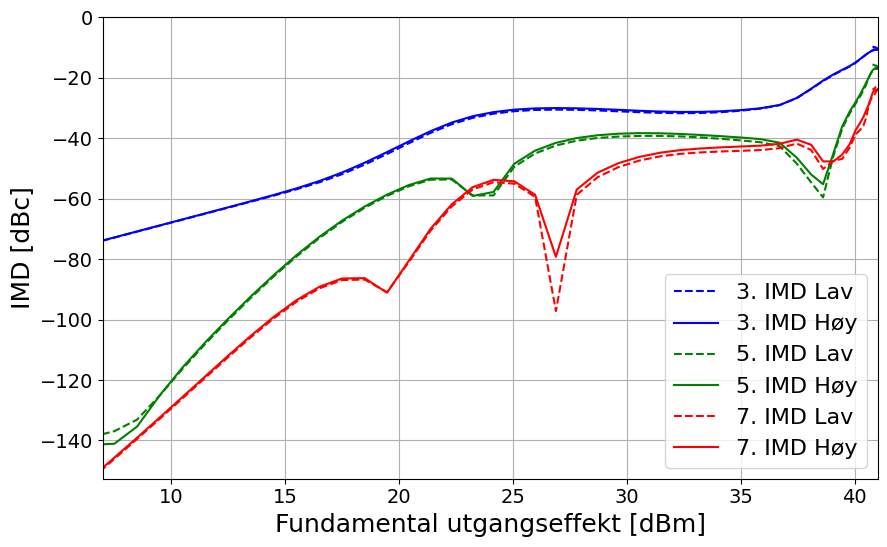

In [11]:
IMD3 = np.loadtxt('Data/Simulering/HB_2Tone/IMD3.csv', delimiter=',', skiprows=16)
IMD3 = pd.DataFrame(IMD3, columns=['P_out_fund', 'IMD3_low', 'IMD3_high'])

IMD5 = np.loadtxt('Data/Simulering/HB_2Tone/IMD5.csv', delimiter=',', skiprows=16)
IMD5 = pd.DataFrame(IMD5, columns=['P_out_fund', 'IMD5_low', 'IMD5_high'])

IMD7 = np.loadtxt('Data/Simulering/HB_2Tone/IMD7.csv', delimiter=',', skiprows=16)
IMD7 = pd.DataFrame(IMD7, columns=['P_out_fund', 'IMD7_low', 'IMD7_high'])

# Determine common y-axis limits
y_min = min(IMD3[['IMD3_low', 'IMD3_high']].min().min(), IMD5[['IMD5_low', 'IMD5_high']].min().min(), IMD7[['IMD7_low', 'IMD7_high']].min().min())
y_max = max(IMD3[['IMD3_low', 'IMD3_high']].max().max(), IMD5[['IMD5_low', 'IMD5_high']].max().max(), IMD7[['IMD7_low', 'IMD7_high']].max().max()) +10

plt.figure(figsize=(10,6))

# Plot IMD3 Simulering
plt.plot(IMD3['P_out_fund'], IMD3['IMD3_low'], 'b--', label='3. IMD Lav')
plt.plot(IMD3['P_out_fund'], IMD3['IMD3_high'], 'b-', label='3. IMD Høy')


# Plot IMD5
plt.plot(IMD5['P_out_fund'], IMD5['IMD5_low'], 'g--', label='5. IMD Lav')
plt.plot(IMD5['P_out_fund'], IMD5['IMD5_high'], 'g-', label='5. IMD Høy')

# Plot IMD7
plt.plot(IMD7['P_out_fund'], IMD7['IMD7_low'], 'r--', label='7. IMD Lav')
plt.plot(IMD7['P_out_fund'], IMD7['IMD7_high'], 'r-', label='7. IMD Høy')

# Set labels and title
plt.xlabel('Fundamental utgangseffekt [dBm]', fontsize=18)
plt.ylabel('IMD [dBc]', fontsize=18)
#plt.title('IMD3, IMD5, and IMD7', fontsize=20)
plt.ylim(y_min, y_max)
plt.xlim(7, 41)

# Add legend
plt.legend(fontsize=16)

# Add grid
plt.grid(True)

# Increase tick label size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.show()

             IMD3_low  IMD3_high
Estimert   -16.741539 -17.120553
Simulering -23.687120 -23.572720


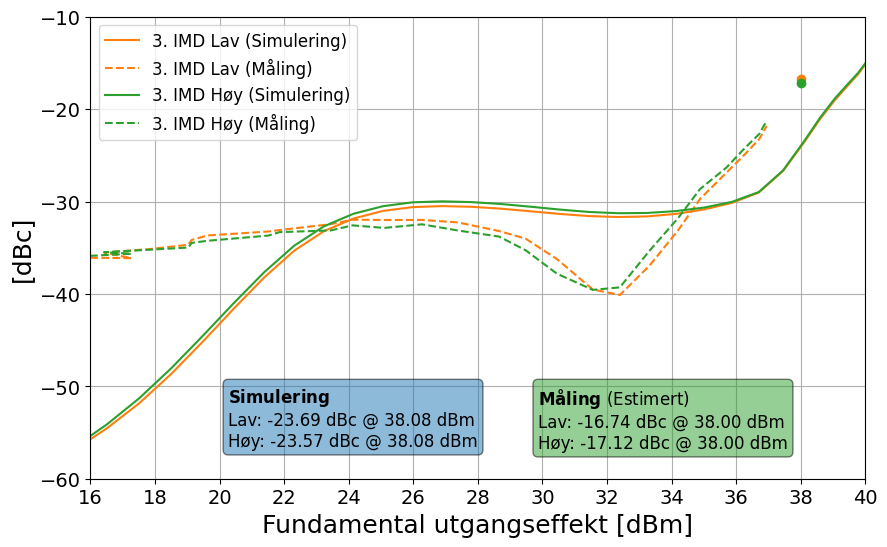

In [21]:
# Define the RFPower range for the polynomial fit of the fundamental and 3rd IMD
rfpower_min_imd3 = 33  # Minimum RFPower value for the 3rd IMD fit
rfpower_max_imd3 = 36  # Maximum RFPower value for the 3rd IMD fit

filtered_data_imd3_low = PA2Tone[(PA2Tone['Po_both'] >= rfpower_min_imd3) & (PA2Tone['Po_both'] <= rfpower_max_imd3)]
filtered_data_imd3_high = PA2Tone[(PA2Tone['Po_both'] >= rfpower_min_imd3) & (PA2Tone['Po_both'] <= rfpower_max_imd3)]

imd3_fit_low = np.polyfit(filtered_data_imd3_low['Po_both'], filtered_data_imd3_low['TOIMD_dBc_low'], 1)
imd3_fit_high = np.polyfit(filtered_data_imd3_high['Po_both'], filtered_data_imd3_high['TOIMD_dBc_high'], 1)

# Interpolate values at Po_both = 38 dBm
po_both_target = 38

# Get interpolated values
imd3_low_meas = np.polyval(imd3_fit_low, po_both_target)
imd3_high_meas = np.polyval(imd3_fit_high, po_both_target)

# Get values for simulated data
closest_idx_sim = (IMD3['P_out_fund'] - po_both_target).abs().idxmin()
imd3_low_sim = IMD3.loc[closest_idx_sim, 'IMD3_low']
imd3_high_sim = IMD3.loc[closest_idx_sim, 'IMD3_high']
closest_po_both_sim = IMD3.loc[closest_idx_sim, 'P_out_fund']

# Print dataframe of the IMD3 values at 38 dBm with 2 decimal points
imd3_values = pd.DataFrame({
    'IMD3_low': [imd3_low_meas, imd3_low_sim],
    'IMD3_high': [imd3_high_meas, imd3_high_sim]
}, index=['Estimert', 'Simulering'])
print(imd3_values)
PA2Tone_excluded = PA2Tone.iloc[:-6]

# Plot the data
plt.figure(figsize=(10, 6))

# Plot IMD3 Simulering
plt.plot(IMD3['P_out_fund'], IMD3['IMD3_low'], color='tab:orange', label='3. IMD Lav (Simulering)')
plt.plot(PA2Tone_excluded['Po_both'], PA2Tone_excluded['TOIMD_dBc_low'], color='tab:orange', label='3. IMD Lav (Måling)', linestyle='--')
plt.plot(IMD3['P_out_fund'], IMD3['IMD3_high'], color='tab:green', label='3. IMD Høy (Simulering)')
plt.plot(PA2Tone_excluded['Po_both'], PA2Tone_excluded['TOIMD_dBc_high'], color='tab:green', label='3. IMD Høy (Måling)', linestyle='--')

# Plot values at 38 dBm
plt.scatter(po_both_target, imd3_low_meas, color='tab:orange', zorder=5)
plt.scatter(po_both_target, imd3_high_meas, color='tab:green', zorder=5)

# Add text boxes for measured data
textstr_meas = r'$\mathbf{Måling}$ (Estimert)' + '\n' + f'Lav: {imd3_low_meas:.2f} dBc @ {po_both_target:.2f} dBm\n' + f'Høy: {imd3_high_meas:.2f} dBc @ {po_both_target:.2f} dBm'
props_meas = dict(boxstyle='round', facecolor='tab:green', alpha=0.5)
plt.gca().text(0.9, 0.2, textstr_meas, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', horizontalalignment='right', bbox=props_meas, multialignment='left')

# Add text boxes for simulated data
textstr_sim = r'$\mathbf{Simulering}$' + '\n' + f'Lav: {imd3_low_sim:.2f} dBc @ {closest_po_both_sim:.2f} dBm\n' + f'Høy: {imd3_high_sim:.2f} dBc @ {closest_po_both_sim:.2f} dBm'
props_sim = dict(boxstyle='round', facecolor='tab:blue', alpha=0.5)
plt.gca().text(0.5, 0.2, textstr_sim, transform=plt.gca().transAxes, fontsize=12,
               verticalalignment='top', horizontalalignment='right', bbox=props_sim, multialignment='left')

# Set labels and title
plt.xlabel('Fundamental utgangseffekt [dBm]', fontsize=18)
plt.ylabel('[dBc]', fontsize=18)

plt.xlim(16, 40)
plt.ylim(-60, -10)
plt.legend(fontsize=12)

# Add grid
plt.grid(True)
plt.xticks(np.arange(16, 41, 2), fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.show()

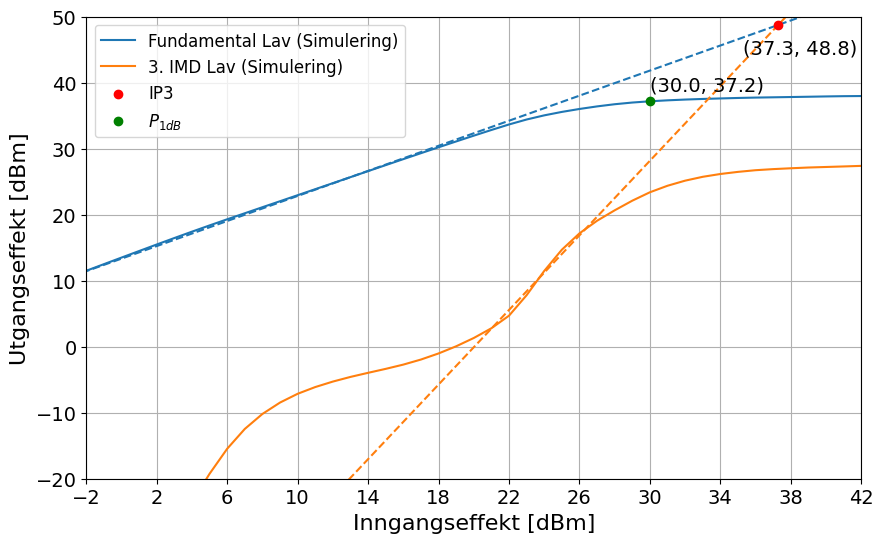

In [13]:
# Load the data
Put_fund_3rd_low = np.loadtxt('Data/Simulering/HB_2Tone/Put_fund_3rd_low.csv', delimiter=',', skiprows=16)
Put_fund_3rd_low = pd.DataFrame(Put_fund_3rd_low, columns=['RFPower', 'Pfund_low', 'P3rd_low'])

# Define the RFPower range for the polynomial fit of the fundamental
rfpower_min_fund = -10  # Minimum RFPower value for the fundamental fit
rfpower_max_fund = 20  # Maximum RFPower value for the fundamental fit

# Define the RFPower range for the polynomial fit of the 3rd IMD
rfpower_min_imd3 = 22.5  # Minimum RFPower value for the 3rd IMD fit
rfpower_max_imd3 = 27.5  # Maximum RFPower value for the 3rd IMD fit

# Filter the data based on the specified RFPower ranges
filtered_data_fund = Put_fund_3rd_low[(Put_fund_3rd_low['RFPower'] >= rfpower_min_fund) & (Put_fund_3rd_low['RFPower'] <= rfpower_max_fund)]
filtered_data_imd3 = Put_fund_3rd_low[(Put_fund_3rd_low['RFPower'] >= rfpower_min_imd3) & (Put_fund_3rd_low['RFPower'] <= rfpower_max_imd3)]

# Calculate the linear fit for the fundamental and 3rd IMD within the specified ranges
fund_fit = np.polyfit(filtered_data_fund['RFPower'], filtered_data_fund['Pfund_low'], 1)
imd3_fit = np.polyfit(filtered_data_imd3['RFPower'], filtered_data_imd3['P3rd_low'], 1)

# Calculate the intersection point (IP3)
ip3_x = (fund_fit[1] - imd3_fit[1]) / (imd3_fit[0] - fund_fit[0])
ip3_y = np.polyval(fund_fit, ip3_x)

# Calculate the 1dB compression point (P1dB)
p1db_x = Put_fund_3rd_low['RFPower'][np.argmax(Put_fund_3rd_low['Pfund_low'] >= (Put_fund_3rd_low['Pfund_low'].max() - 1))]
p1db_y = Put_fund_3rd_low['Pfund_low'][np.argmax(Put_fund_3rd_low['Pfund_low'] >= (Put_fund_3rd_low['Pfund_low'].max() - 1))]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(Put_fund_3rd_low['RFPower'], Put_fund_3rd_low['Pfund_low'], label='Fundamental Lav (Simulering)')
plt.plot(Put_fund_3rd_low['RFPower'], Put_fund_3rd_low['P3rd_low'], label='3. IMD Lav (Simulering)')

# Plot the linear fits
plt.plot(Put_fund_3rd_low['RFPower'], np.polyval(fund_fit, Put_fund_3rd_low['RFPower']), '--', color='tab:blue')
plt.plot(Put_fund_3rd_low['RFPower'], np.polyval(imd3_fit, Put_fund_3rd_low['RFPower']), '--', color='tab:orange')

# Plot the IP3 point
plt.scatter(ip3_x, ip3_y, color='red', zorder=5, label='IP3')
plt.text(ip3_x-2, ip3_y-5, f'({ip3_x:.1f}, {ip3_y:.1f})', fontsize=14, verticalalignment='bottom')

# Plot the 1dB compression point
plt.scatter(p1db_x, p1db_y, color='green', zorder=5, label='$P_{1dB}$')
plt.text(p1db_x, p1db_y+1, f'({p1db_x:.1f}, {p1db_y:.1f})', fontsize=14, verticalalignment='bottom')

plt.xlabel('Inngangseffekt [dBm]', fontsize=16)
plt.ylabel('Utgangseffekt [dBm]', fontsize=16)
#plt.title('Fundamental og 3. IMD Lav', fontsize=18)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)

plt.xlim(-2, 42)
plt.ylim(-20, 50)
plt.xticks(np.arange(-2, 42 + 1, 4), fontsize=14)
plt.yticks(fontsize=14)

plt.show()


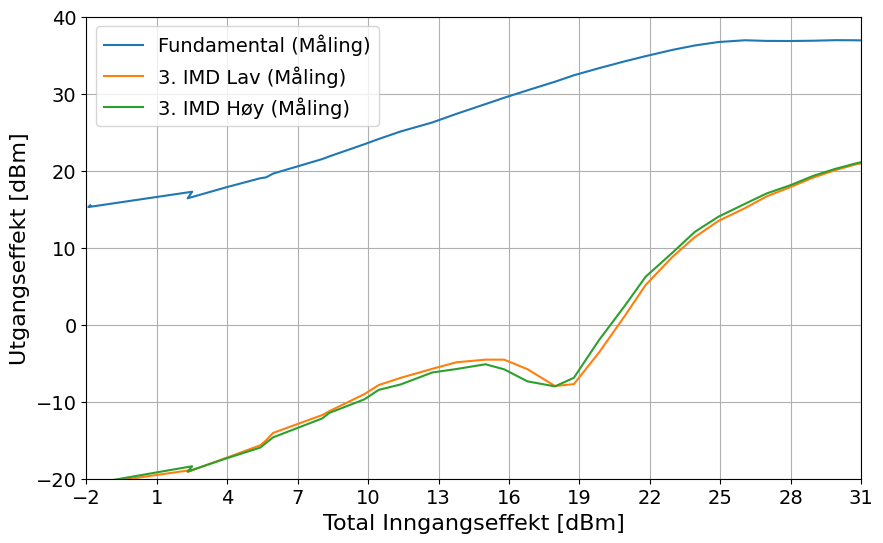

In [14]:
# Plot the data
plt.figure(figsize=(10, 6))

plt.plot(PA2Tone['Pi_both'], PA2Tone['Po_both'], label='Fundamental (Måling)', color='tab:blue')
plt.plot(PA2Tone['Pi_both'], PA2Tone['TOIMD_dBc_low'] + PA2Tone['Po_both'], label='3. IMD Lav (Måling)', color='tab:orange')
plt.plot(PA2Tone['Pi_both'], PA2Tone['TOIMD_dBc_high'] + PA2Tone['Po_both'], label='3. IMD Høy (Måling)', color='tab:green')

plt.xlabel('Total Inngangseffekt [dBm]', fontsize=16)
plt.ylabel('Utgangseffekt [dBm]', fontsize=16)
plt.legend(loc='upper left', fontsize=14)
plt.grid(True)

plt.xlim(-2, 31)
plt.ylim(-20, 40)
plt.xticks(np.arange(-2, 31+1, 3), fontsize=14)
plt.yticks(fontsize=14)

plt.show()

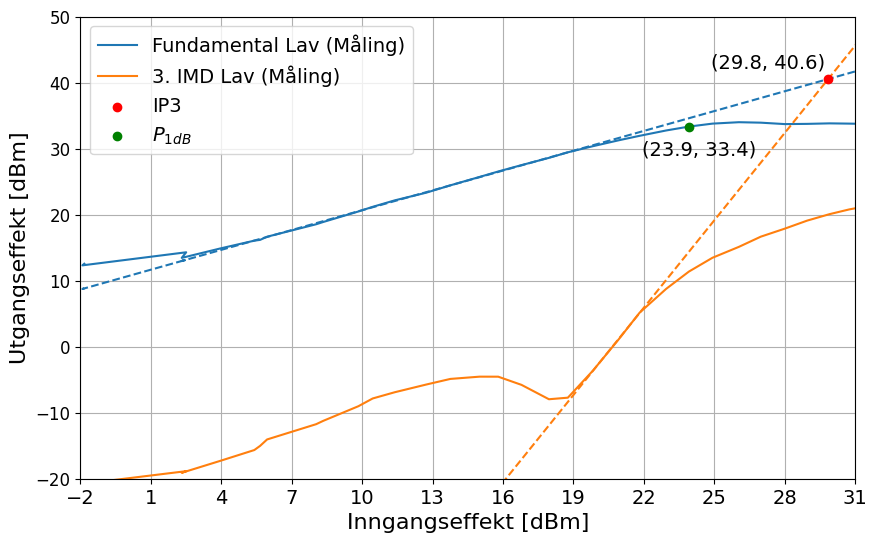

In [15]:
# Define the RFPower range for the polynomial fit of the fundamental and 3rd IMD
rfpower_min_fund = 3  # Minimum RFPower value for the fundamental fit
rfpower_max_fund = 19  # Maximum RFPower value for the fundamental fit
rfpower_min_imd3 = 19  # Minimum RFPower value for the 3rd IMD fit
rfpower_max_imd3 = 22  # Maximum RFPower value for the 3rd IMD fit

# Filter the data based on the specified RFPower ranges
filtered_data_fund = PA2Tone[(PA2Tone['Pi_both'] >= rfpower_min_fund) & (PA2Tone['Pi_both'] <= rfpower_max_fund)]
filtered_data_imd3_low = PA2Tone[(PA2Tone['Pi_both'] >= rfpower_min_imd3) & (PA2Tone['Pi_both'] <= rfpower_max_imd3)]
filtered_data_imd3_high = PA2Tone[(PA2Tone['Pi_both'] >= rfpower_min_imd3) & (PA2Tone['Pi_both'] <= rfpower_max_imd3)]

# Calculate the linear fit for the fundamental and 3rd IMD within the specified ranges
fund_fit = np.polyfit(filtered_data_fund['Pi_both'], filtered_data_fund['Po_dBm_f1'], 1)
imd3_fit_low = np.polyfit(filtered_data_imd3_low['Pi_both'], filtered_data_imd3_low['TOIMD_dBc_low'] + filtered_data_imd3_low['Po_both'], 1)

# Calculate the intersection point (IP3)
ip3_x_low = (fund_fit[1] - imd3_fit_low[1]) / (imd3_fit_low[0] - fund_fit[0])
ip3_y_low = np.polyval(fund_fit, ip3_x_low)



# Calculate the 1dB compression point (P1dB)
p1db_x = PA2Tone['Pi_both'][np.argmax(PA2Tone['Po_dBm_f1'] >= (PA2Tone['Po_dBm_f1'].max() - 1))]
p1db_y = PA2Tone['Po_dBm_f1'][np.argmax(PA2Tone['Po_dBm_f1'] >= (PA2Tone['Po_dBm_f1'].max() - 1))]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(PA2Tone['Pi_both'], PA2Tone['Po_dBm_f1'], label='Fundamental Lav (Måling)')
plt.plot(PA2Tone['Pi_both'], PA2Tone['TOIMD_dBc_low'] + PA2Tone['Po_both'], label='3. IMD Lav (Måling)')

# Plot the linear fits
plt.plot(PA2Tone['Pi_both'], np.polyval(fund_fit, PA2Tone['Pi_both']), '--', color='tab:blue')
plt.plot(PA2Tone['Pi_both'], np.polyval(imd3_fit_low, PA2Tone['Pi_both']), '--', color='tab:orange')

# Plot the IP3 points
plt.scatter(ip3_x_low, ip3_y_low, color='red', zorder=5, label='IP3')
plt.text(ip3_x_low-5, ip3_y_low+1, f'({ip3_x_low:.1f}, {ip3_y_low:.1f})', fontsize=14, verticalalignment='bottom')

# Plot the 1dB compression point
plt.scatter(p1db_x, p1db_y, color='green', zorder=5, label='$P_{1dB}$')
plt.text(p1db_x-2, p1db_y-5,f'\n({p1db_x:.1f}, {p1db_y:.1f})', fontsize=14, verticalalignment='bottom')

plt.xlabel('Inngangseffekt [dBm]', fontsize=16)
plt.ylabel('Utgangseffekt [dBm]', fontsize=16)
plt.legend(loc='upper left', fontsize=14)
plt.grid(True)

plt.xlim(-2, 31)
plt.ylim(-20, 50)
plt.xticks(np.arange(-2, 32, 3), fontsize=14)
plt.yticks(fontsize=12)

plt.show()